# Applied Data Science Capstone

## Selecting Neighbourhoods in Toronto for Establishing a New Coffee Shop

### Introduction: Business Problem
A business organization is considering to setup a new coffee shop in Toronto. This business organization is the audience of the data 
In this regard, it is desired to provide answers to the following questions:
1.	Which neighbourhoods in Toronto have high business activity in terms of existing outlets and venues?
2.	Is coffee shop a viable business category in Toronto? Do enough coffee shops exist to prove existence of a coffee consumer market?
3.	What are popular business venues in Toronto? Are some coffee shops popular venues?
4.	Which neighbourhoods in Toronto have highest and lowest number of coffee shops?
5.	Which neighbourhoods in Toronto have high business activity and low competition from existing coffee shops? These neighbourhoods will be potential places or areas to be selected for establishing a new coffee shop.


In [1]:
# import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

from geopy.geocoders import Nominatim
import folium
import geocoder # import geocoder

print('Libraries imported.')

Libraries imported.


In [2]:
# get text of the webpage
website_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M' # store website address
website_get = requests.get(website_url) # store response of the 'GET' http request
website_text = website_get.text # store text received in response to the 'GET' response

In [3]:
# store text of the webpage parsed through parser
soup_text = BeautifulSoup(website_text, 'html.parser')
#print(soup_text)

In [4]:
# find table using class attributes
data_table = soup_text.find('table', {'class':'wikitable sortable'})
#data_table

In [5]:
# find all rows in the table through 'tr' tag
data_rows = data_table.find_all('tr')

In [6]:
# create an empty list
data_list = []

# loop through all rows found in the table
for data_row in data_rows:
    # get text of each row
    # split text on next line '\n' character
    # remove first and last empty items
    row = data_row.text.split('\n')[1:-1]
    # append row as list to data_list
    data_list.append(row)

# display first five rows
data_list[0:5]

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village']]

In [7]:
# obtain first row to later use as column headings
data_head = data_list[0]

In [8]:
# create data frame using all items from first item onwards; assign column names
neighborhoods_df = pd.DataFrame(data=data_list[1:], columns=data_head)

In [9]:
# display head (first five rows) of the data frame
neighborhoods_df.head(3)

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods


In [10]:
# display shape of the data frame
neighborhoods_df.shape

(287, 3)

In [11]:
# get index of rows in data frame where 'Borough' column is 'Not Assigned'
neighborhoods_borough_not_assigned_index = neighborhoods_df.index[neighborhoods_df['Borough'] == 'Not assigned']

In [12]:
neighborhoods_borough_not_assigned_index.shape

(77,)

In [13]:
#neighborhoods_df.drop(neighborhoods_borough_not_assigned_index, axis = 'index', inplace = True)
neighborhoods_df.drop(index = neighborhoods_borough_not_assigned_index, inplace = True)

In [14]:
# display shape of the data frame
neighborhoods_df.shape

(210, 3)

In [15]:
# group data frame using 'Postcode' and 'Borough' columns
# join 'Neighbourhood' values using comma
neighborhoods_df = pd.DataFrame(neighborhoods_df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply( ', '.join))

In [16]:
# reset index of grouped data frame
neighborhoods_df.reset_index(inplace = True)

In [17]:
# display head of the grouped data frame
neighborhoods_df.head(3)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"


In [18]:
neighborhoods_df.shape

(103, 3)

Get the geographical coordinates of the neighborhoods

Given that this package can be very unreliable, in case you are not able to get the geographical coordinates of the neighborhoods using the Geocoder package, here is a link to a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data

In [19]:
geo_coordinates_df = pd.read_csv('https://cocl.us/Geospatial_data')

In [20]:
geo_coordinates_df.head(3)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711


In [21]:
geo_coordinates_df.shape

(103, 3)

In [22]:
neighborhoods_coord_df = neighborhoods_df.merge(geo_coordinates_df, how='left', left_on='Postcode', right_on='Postal Code')

In [23]:
neighborhoods_coord_df.head(3)

,Postcode,Borough,Neighbourhood,Postal Code,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",M1B,43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",M1C,43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711


In [24]:
neighborhoods_coord_df = neighborhoods_coord_df.drop(columns='Postal Code')

In [25]:
neighborhoods_coord_df.to_csv('neighborhoods_coord_df.csv', index=False)
neighborhoods_coord_df.head(3)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711


In [26]:
neighborhoods_coord_df.shape

(103, 5)

Display the map

In [27]:
address = 'Toronto, ON, Canada'
geolocator = Nominatim(user_agent="my_explorer")

location = geolocator.geocode(address)

latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [28]:
# latitude and longitude input manually since the geolocator service is timing out
latitude = 43.653963
longitude = -79.387207

In [29]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(neighborhoods_coord_df['Latitude'], neighborhoods_coord_df['Longitude'], neighborhoods_coord_df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

#### Define Foursquare Credentials and Version

In [30]:
CLIENT_ID = '######################################' # your Foursquare ID
CLIENT_SECRET = '########################################' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [31]:
neighborhoods_coord_df.loc[0, 'Neighbourhood']

'Rouge, Malvern'

Get the neighborhood's latitude and longitude values.

In [32]:
neighborhood_latitude = neighborhoods_coord_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods_coord_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods_coord_df.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Rouge, Malvern are 43.806686299999996, -79.19435340000001.


#### Now, let's get the top 100 venues that are in Rouge, Malvern within a radius of 1000 meters.

First, let's create the GET request URL. Name your URL **url**.

In [33]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

In [34]:
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=##############################&client_secret=##########################################&v=20180605&ll=43.806686299999996,-79.19435340000001&radius=1000&limit=100'

Send the GET request and examine the resutls

In [35]:
results = requests.get(url).json()
# results

We know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [36]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [37]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Wendy's,Fast Food Restaurant,43.802008,-79.198080
1,Wendy's,Fast Food Restaurant,43.807448,-79.199056
2,Caribbean Wave,Caribbean Restaurant,43.798558,-79.195777
3,Staples Morningside,Paper / Office Supplies Store,43.800285,-79.196607
4,Tim Hortons,Coffee Shop,43.802000,-79.198169


And how many venues were returned by Foursquare?

In [38]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

17 venues were returned by Foursquare.


## Explore Neighborhoods in Toronto

#### Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [39]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


#### Now write the code to run the above function on each neighborhood and create a new dataframe called *toronto_venues*.

In [489]:
toronto_venues = getNearbyVenues(names=neighborhoods_coord_df['Neighbourhood'],
                                   latitudes=neighborhoods_coord_df['Latitude'],
                                   longitudes=neighborhoods_coord_df['Longitude']
                                  )

toronto_venues.to_csv("toronto_venues.csv", index=False)
print ('{} venues have been downloaded and saved.'.format(toronto_venues.shape[0]))

2213 venues have been downloaded and saved.


#### Let's check the size of the resulting dataframe

In [40]:
toronto_venues = pd.read_csv('toronto_venues.csv')
print ('{} venues have been imported.'.format(toronto_venues.shape[0]))

2213 venues have been imported.


In [41]:
print(toronto_venues.shape)
toronto_venues.head()

(2213, 7)


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge, Malvern",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
3,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target


## Popular Neighborhoods in Toronto

#### Let us summarize the data for number of venues in each neighbourhoods

We shall count the number of neighbourhoods in the sample, reset index and then rename columns.

In [42]:
toronto_venues_neigh = toronto_venues['Neighbourhood'].value_counts().to_frame()
toronto_venues_neigh.reset_index(inplace=True)
toronto_venues_neigh.rename({'index':'Neighbourhood', 'Neighbourhood':'Number of Venues'}, axis='columns', inplace=True)

In [43]:
toronto_venues_neigh.head()

,Neighbourhood,Number of Venues
0,St. James Town,100
1,"Ryerson, Garden District",100
2,"Commerce Court, Victoria Hotel",100
3,"First Canadian Place, Underground city",100
4,"Design Exchange, Toronto Dominion Centre",100


We shall find out the top 10 neighbourhoods in terms of number of venues.

In [44]:
toronto_venues_neigh_top = toronto_venues_neigh.nlargest(10, 'Number of Venues', keep = 'all')
print(toronto_venues_neigh_top.shape)
toronto_venues_neigh_top.head(3)

(10, 2)


,Neighbourhood,Number of Venues
0,St. James Town,100
1,"Ryerson, Garden District",100
2,"Commerce Court, Victoria Hotel",100


Let us draw a graph of the popular neighbourhoods in Toronto.

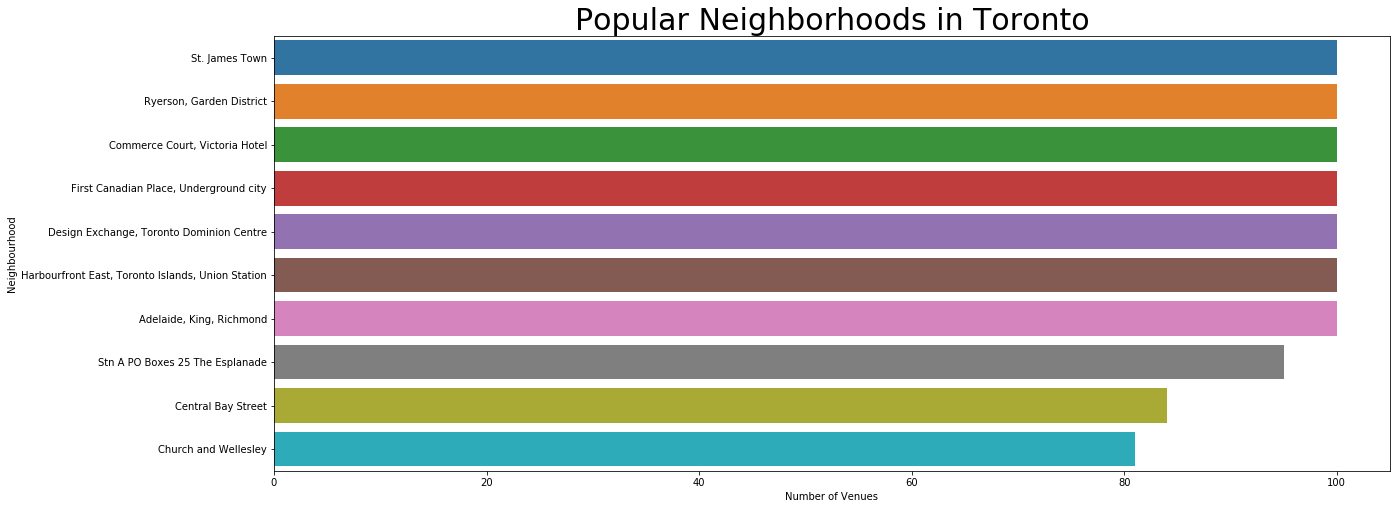

In [45]:
plt.figure(figsize=(20,8))
sns_plot = sns.barplot(y='Neighbourhood', x='Number of Venues', data=toronto_venues_neigh_top)
sns_plot.axes.set_title('Popular Neighborhoods in Toronto',fontsize=30)
plt.savefig('toronto_venues_neigh_top.png')

## Popular Venue Categories in Toronto

#### Let us summarize the data for number of venue categories in each neighbourhoods

We shall count the number of venue categories in the sample, reset index and then rename columns.

In [46]:
toronto_venues_venue_cat = toronto_venues['Venue Category'].value_counts().to_frame()
toronto_venues_venue_cat.reset_index(inplace=True)
toronto_venues_venue_cat.rename({'index':'Venue Category', 'Venue Category':'Number of Venues'}, axis='columns', inplace=True)

In [47]:
toronto_venues_venue_cat.head()

,Venue Category,Number of Venues
0,Coffee Shop,193
1,Café,99
2,Restaurant,64
3,Pizza Place,50
4,Park,50


We shall find out the top 10 venue categories in terms of number of venues.

In [48]:
toronto_venues_venue_cat_top = toronto_venues_venue_cat.nlargest(10, 'Number of Venues', keep = 'all')
toronto_venues_venue_cat_top.head(3)

,Venue Category,Number of Venues
0,Coffee Shop,193
1,Café,99
2,Restaurant,64


Let us draw a graph of the popular venue categories in Toronto.

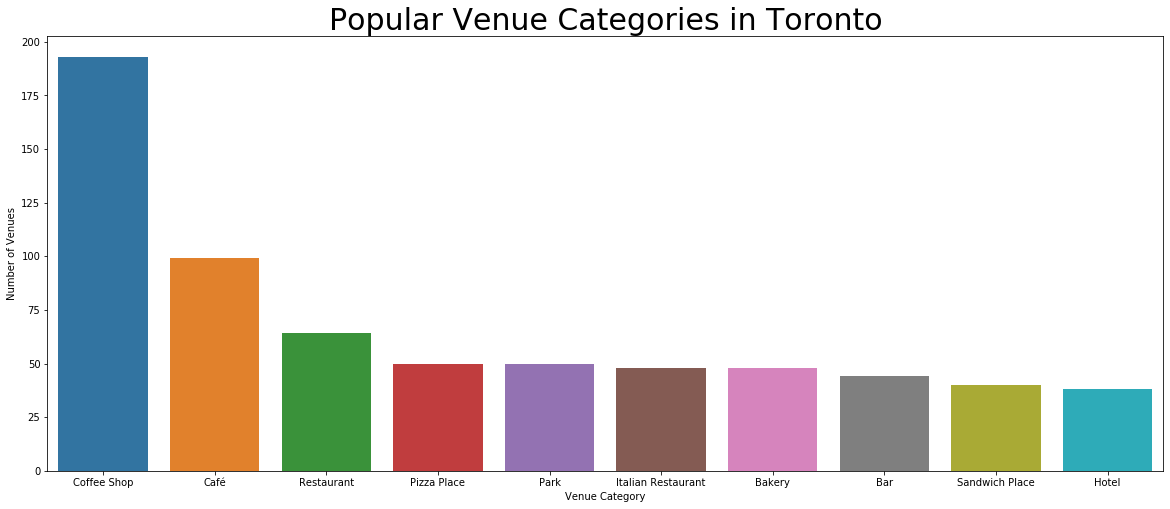

In [49]:
plt.figure(figsize=(20,8))
sns_plot = sns.barplot(x='Venue Category', y='Number of Venues', data=toronto_venues_venue_cat_top)
sns_plot.axes.set_title('Popular Venue Categories in Toronto',fontsize=30)
plt.savefig('toronto_venues_venue_cat_top.png', transparent=True)

We learn from the above graph that *coffee shop* is the most popular category followed by cafe.

## Popular Venues in Toronto

#### Let us summarize the data for number of venues (brands) in each neighbourhood in Toronto.

We shall count the number of venues (brands) in the sample, reset index and then rename columns.

In [50]:
toronto_venues_venues = toronto_venues['Venue'].value_counts().to_frame()
toronto_venues_venues.reset_index(inplace=True)
toronto_venues_venues.rename({'index':'Venue', 'Venue':'Number of Locations'}, axis='columns', inplace=True)

In [51]:
toronto_venues_venues.head()

,Venue,Number of Locations
0,Starbucks,74
1,Tim Hortons,39
2,Subway,28
3,LCBO,17
4,Shoppers Drug Mart,16


We shall find out the top 10 venue categories in terms of number of venues.

In [52]:
toronto_venues_venues_top = toronto_venues_venues.nlargest(10, 'Number of Locations', keep = 'all')
toronto_venues_venues_top.head(3)

,Venue,Number of Locations
0,Starbucks,74
1,Tim Hortons,39
2,Subway,28


Let us draw a graph of the popular venue categories in Toronto.

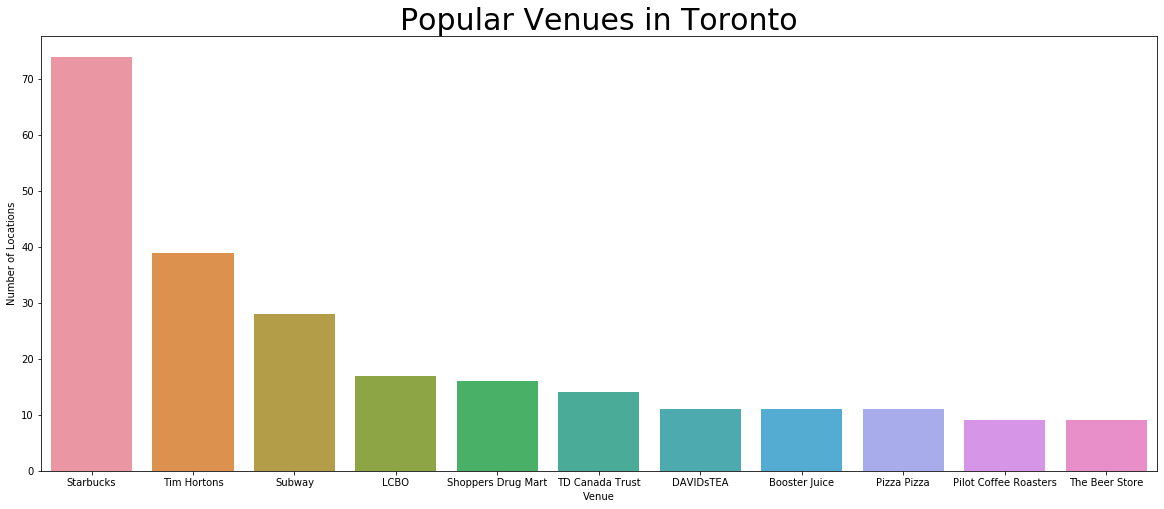

In [53]:
plt.figure(figsize=(20,8))
sns_plot = sns.barplot(x='Venue', y='Number of Locations', data=toronto_venues_venues_top)
sns_plot.axes.set_title('Popular Venues in Toronto',fontsize=30)
plt.savefig('toronto_venues_venues_top.png')

The above graph shows a variety of venues among the top 10 popular venues with **coffee shops** occupying the top two positions.

## Analyze number of Coffee Shops in Each Neighborhoods

### From analysis of venue categories, we have learnt that *Coffee Shops* are the most popular category

Let's check how many coffee shop venues were returned for each neighborhood

#### Let's find out how many unique neighbourhoods can be served from all the returned coffee shops

In [54]:
toronto_venues_coffee_shops = toronto_venues[toronto_venues['Venue Category'] == 'Coffee Shop']
toronto_venues_coffee_shops.reset_index(inplace=True)

In [55]:
print('There are {} coffee shops in {} neighbourhoods.'.format(len(toronto_venues_coffee_shops['Venue']), len(toronto_venues_coffee_shops['Neighbourhood'].unique())))

There are 193 coffee shops in 49 neighbourhoods.


#### Let find our number of coffee shops in each neighbourhood.

In [56]:
toronto_venues_neigh_coffee_shops = toronto_venues_coffee_shops['Neighbourhood'].value_counts().to_frame()
toronto_venues_neigh_coffee_shops.reset_index(inplace=True)
toronto_venues_neigh_coffee_shops.rename({'index' : 'Neighbourhood', 'Neighbourhood' : 'Number of Coffee Shops'}, axis='columns', inplace=True, errors= 'raise')
print(toronto_venues_neigh_coffee_shops.shape)
toronto_venues_neigh_coffee_shops.head()

(49, 2)


,Neighbourhood,Number of Coffee Shops
0,Central Bay Street,14
1,"First Canadian Place, Underground city",13
2,"Harbourfront East, Toronto Islands, Union Station",12
3,"Commerce Court, Victoria Hotel",12
4,"Design Exchange, Toronto Dominion Centre",12


### Nighbourhoods Having Highest Number of Coffee Shops

Let us draw a graph of top 10 neighbourhoods in terms of number of coffee shops.

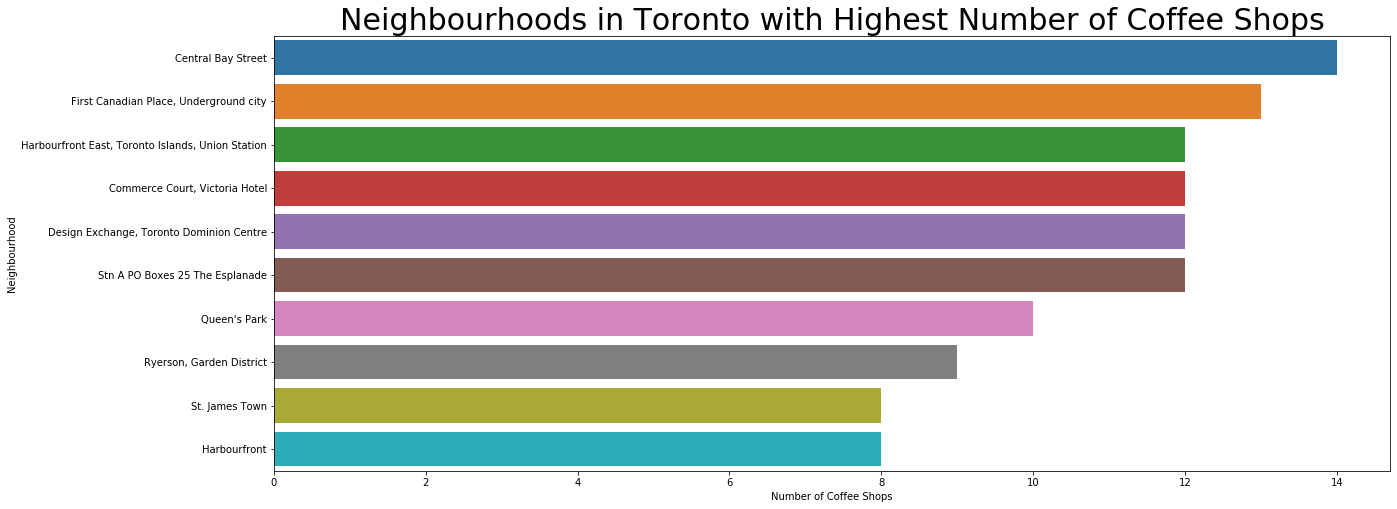

In [58]:
plt.figure(figsize=(20, 8))
sns_plot = sns.barplot(x='Number of Coffee Shops', y= 'Neighbourhood', \
                       data = toronto_venues_neigh_coffee_shops.nlargest(10, columns='Number of Coffee Shops', keep='all'))
sns_plot.axes.set_title('Neighbourhoods in Toronto with Highest Number of Coffee Shops',fontsize=30)
plt.savefig('toronto_venues_neigh_max_coffee_shops.png')

## Popular Coffee Shop Venues (Brands)

#### Let us analyze data to find out the popular coffee shop venues.

We shall count number of coffee shop venues, reset the index of dataframe and rename columns.

In [59]:
toronto_venues_coffee_shops_count = toronto_venues_coffee_shops['Venue'].value_counts().to_frame()
toronto_venues_coffee_shops_count.reset_index(inplace=True)
toronto_venues_coffee_shops_count.rename({'index':'Coffee Shop', 'Venue':'Count'}, axis='columns', inplace=True)


We shall filter the data to find out top 5 coffee shop venues.

In [60]:
toronto_venues_coffee_shops_top = toronto_venues_coffee_shops_count.nlargest(5, columns='Count', keep='all')

In [61]:
print(toronto_venues_coffee_shops_top.shape)
toronto_venues_coffee_shops_top.head()

(5, 2)


,Coffee Shop,Count
0,Starbucks,74
1,Tim Hortons,39
2,Pilot Coffee Roasters,9
3,Dineen @CommerceCourt,5
4,Second Cup,4


Let us draw a graph of the top 5 popular coffee shop venues in Toronto.

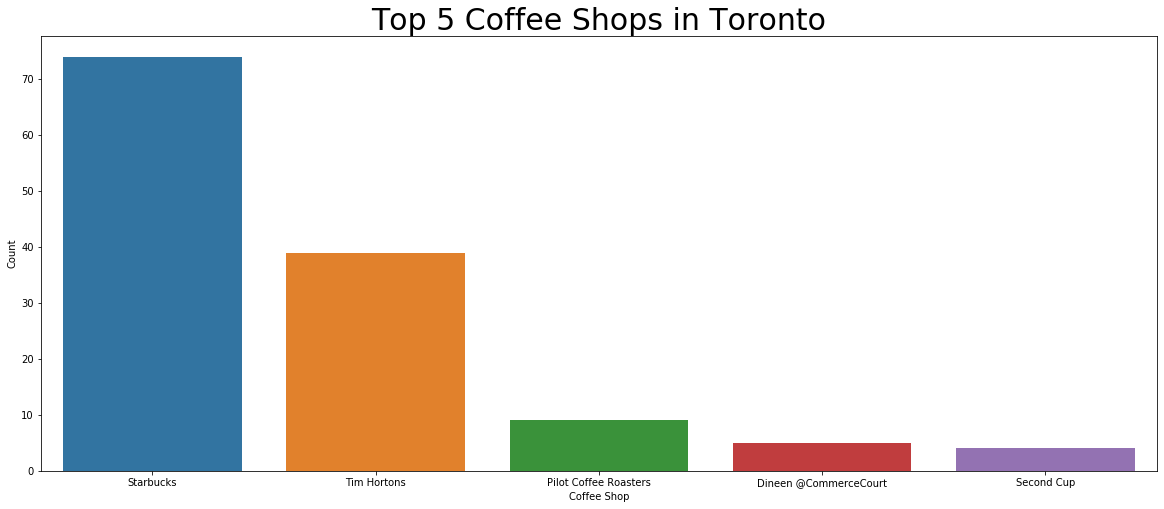

In [62]:
plt.figure(figsize=(20, 8))
sns_plot = sns.barplot(x='Coffee Shop', y= 'Count', \
                       data = toronto_venues_coffee_shops_top)
sns_plot.axes.set_title('Top 5 Coffee Shops in Toronto',fontsize=30)
plt.savefig('toronto_venues_coffee_shops_top.png')

We learn that in Toronto Starbucks in the most popular coffee shop venue followed by Tim Hortons.

## Analysis of Coffee Shops in Neighborhoods

### Now we will draw a comparison of the total venues vis-a-vis coffee shops in Toronto.

In [78]:
toronto_venues_neigh.head(3)

,Neighbourhood,Number of Venues
0,St. James Town,100
1,"Ryerson, Garden District",100
2,"Commerce Court, Victoria Hotel",100


In [79]:
toronto_venues_neigh_coffee_shops.head(3)

,Neighbourhood,Number of Coffee Shops
0,Central Bay Street,14
1,"First Canadian Place, Underground city",13
2,"Harbourfront East, Toronto Islands, Union Station",12


We shall merge the dataframe containing all venues and the dataframe containing cofee shops.

In [80]:
toronto_venues_neigh_and_coffee = toronto_venues_neigh.merge(toronto_venues_neigh_coffee_shops, how='inner')
toronto_venues_neigh_and_coffee['Percent of Coffee Shops'] = toronto_venues_neigh_and_coffee['Number of Coffee Shops'] /  toronto_venues_neigh_and_coffee['Number of Venues']

In [81]:
toronto_venues_neigh_and_coffee.head()

,Neighbourhood,Number of Venues,Number of Coffee Shops,Percent of Coffee Shops
0,St. James Town,100,8,0.08
1,"Ryerson, Garden District",100,9,0.09
2,"Commerce Court, Victoria Hotel",100,12,0.12
3,"First Canadian Place, Underground city",100,13,0.13
4,"Design Exchange, Toronto Dominion Centre",100,12,0.12


### Number of Coffee Shops vs Total Venues

We shall draw a scatter plot of the number of venues against the number of coffee shops. The size of each dot represents the number of coffee shops in each neighbourhood.

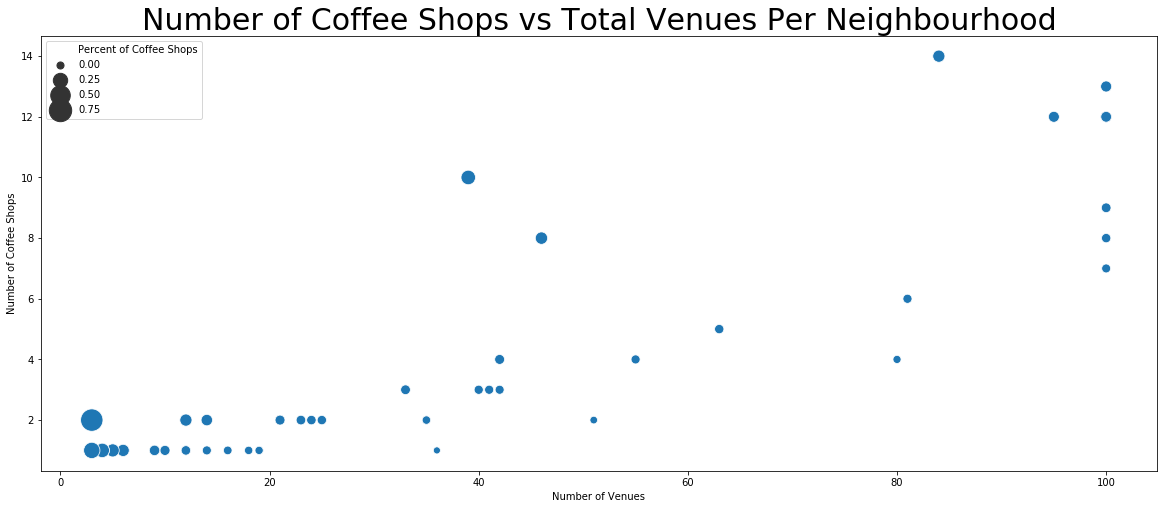

In [82]:
plt.figure(figsize=(20,8))
sns_plot = sns.scatterplot(y='Number of Coffee Shops', x='Number of Venues', \
                                 size='Percent of Coffee Shops', sizes = (50, 500), \
                                 data=toronto_venues_neigh_and_coffee)
sns_plot.axes.set_title('Number of Coffee Shops vs Total Venues Per Neighbourhood', fontsize=30)
plt.savefig('toronto_venues_neigh_and_coffee_scatter.png')

### Correlation Between the Number of Coffee Shops and Total Venues

We shall draw a scatter plot of the number of venues against the number of coffee shops. The size of each dot represents the number of coffee shops in each neighbourhood.

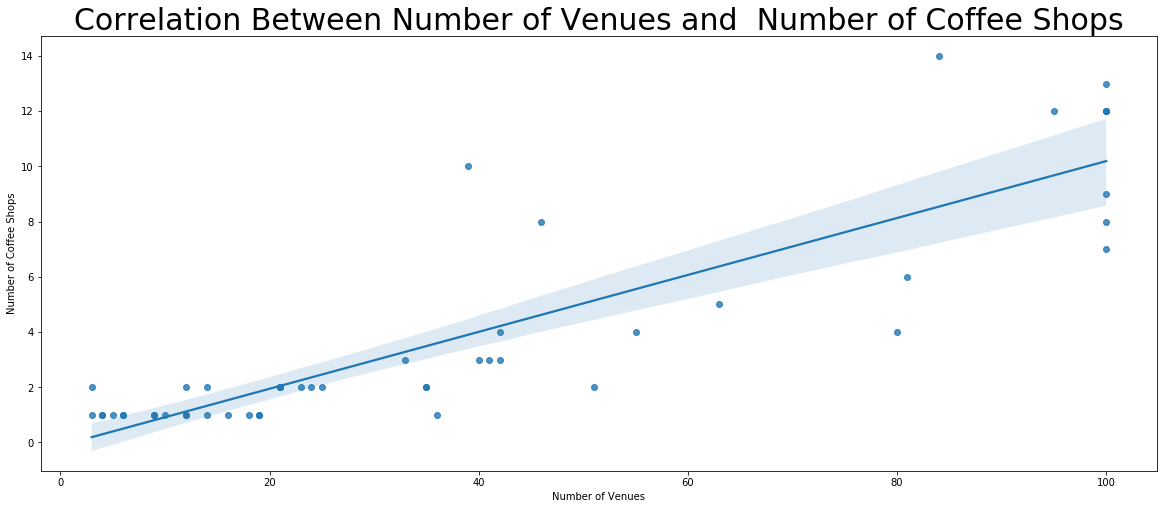

In [83]:
plt.figure(figsize=(20,8))
sns_plot = sns.regplot(y='Number of Coffee Shops', x='Number of Venues', \
                                 #size='Percent of Coffee Shops', sizes = (50, 300), \
                                 data=toronto_venues_neigh_and_coffee)
sns_plot.axes.set_title('Correlation Between Number of Venues and  Number of Coffee Shops', fontsize=30)
plt.savefig('toronto_venues_neigh_and_coffee_regression.png')

### Nighbourhoods Having Least Number of Coffee Shops

#### Let us analyze data to find out neighbourhoods having least number of coffee shops.

We shall count number of coffee shop venues, reset the index of dataframe and rename columns.

In [84]:
neighbourhoods_with_min_coffee = toronto_venues_neigh_and_coffee.nsmallest(10, columns='Number of Coffee Shops', keep='all')
neighbourhoods_with_min_coffee.head()

,Neighbourhood,Number of Venues,Number of Coffee Shops,Percent of Coffee Shops
20,"Harbord, University of Toronto",36,1,0.027778
30,Thorncliffe Park,19,1,0.052632
31,"Dovercourt Village, Dufferin",19,1,0.052632
32,Christie,18,1,0.055556
33,"CN Tower, Bathurst Quay, Island airport, Harbo...",16,1,0.062500


Let us draw a bar chart of the neighbourhoods having least number of coffee shops.

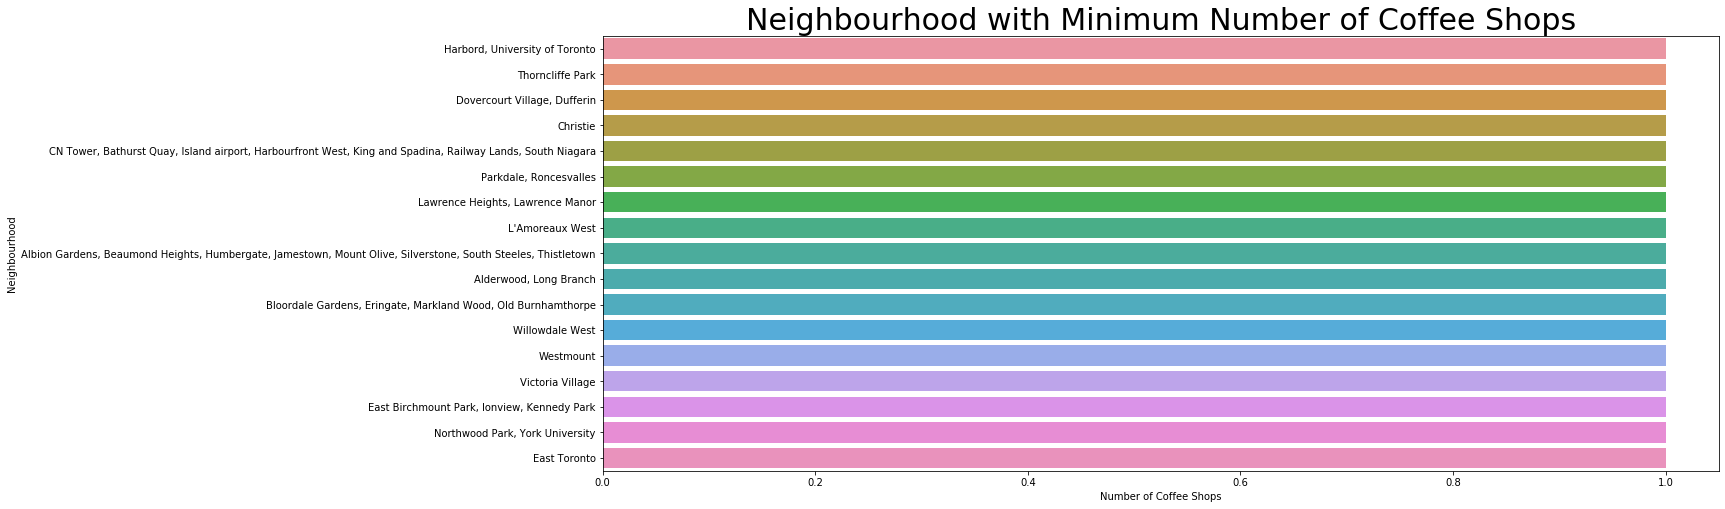

In [85]:
plt.figure(figsize=(20,8))
sns_plot = sns.barplot(y='Neighbourhood', x='Number of Coffee Shops', data=neighbourhoods_with_min_coffee)
sns_plot.set_title('Neighbourhood with Minimum Number of Coffee Shops',fontsize=30)
plt.savefig('neighbourhoods_with_min_coffee.png')

### Potential Neighbourhoods for Opening a Coffee Shop

Towards the last part of our analysis, we shall filter out a list of potential neighbourhoods for opening a new coffee shop.

Our criteria for selection of a potential neighbourhood for opening a new coffee shop are:

1. The number of total venues in the neighbourhood must be 50 or more. This is to ensure that ample commercial activity and customer base exists in the neighbourhood.
2. The number of existing coffee shops should be less than 20% of the total venues in that neighbourhood. This is to avoid entering a market which is already crowded by competing coffee shops.

In [86]:
# define the condition for seletion of potential neighbourhoods.
potential_coffee_sites_condition = (toronto_venues_neigh_and_coffee['Number of Venues'] >= 50) & \
                            (toronto_venues_neigh_and_coffee['Percent of Coffee Shops'] < 0.2)
# apply the condition to filter out potential neighbourhoods for selection
potential_coffee_sites = toronto_venues_neigh_and_coffee[potential_coffee_sites_condition]

In [87]:
potential_coffee_sites

,Neighbourhood,Number of Venues,Number of Coffee Shops,Percent of Coffee Shops
0,St. James Town,100,8,0.080000
1,"Ryerson, Garden District",100,9,0.090000
2,"Commerce Court, Victoria Hotel",100,12,0.120000
3,"First Canadian Place, Underground city",100,13,0.130000
4,"Design Exchange, Toronto Dominion Centre",100,12,0.120000
5,"Harbourfront East, Toronto Islands, Union Station",100,12,0.120000
6,"Adelaide, King, Richmond",100,7,0.070000
7,Stn A PO Boxes 25 The Esplanade,95,12,0.126316
8,Central Bay Street,84,14,0.166667
9,Church and Wellesley,81,6,0.074074


Fourteen neighbourhoods have been identified as potential areas for opening a new coffee shop venue.

## Mark Potential Nieghbourhoods on the Map

We will mark the identified potential neighbourhoods on the map for visual representation.

In [92]:
# Merge the list of potential neighbourhoods with the dataframe of coordinates
potential_coffee_sites_coords=potential_coffee_sites.merge(neighborhoods_coord_df, how='left')
potential_coffee_sites_coords.head(3)

,Neighbourhood,Number of Venues,Number of Coffee Shops,Percent of Coffee Shops,Postcode,Borough,Latitude,Longitude
0,St. James Town,100,8,0.08,M5C,Downtown Toronto,43.651494,-79.375418
1,"Ryerson, Garden District",100,9,0.09,M5B,Downtown Toronto,43.657162,-79.378937
2,"Commerce Court, Victoria Hotel",100,12,0.12,M5L,Downtown Toronto,43.648198,-79.379817


In [91]:
map_toronto = folium.Map(location=[latitude, longitude], tiles='Stamen Toner', zoom_start=11)

# add markers to map
for lat, lng, label in zip(potential_coffee_sites_coords['Latitude'], potential_coffee_sites_coords['Longitude'], potential_coffee_sites_coords['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False,
        icon=folium.Icon(color='red', icon='info-sign')).add_to(map_toronto)  

map_toronto

### Conclusion
From the above analysis, we learn that:
1.	A number of neighbourhoods in Toronto have high business activity in terms of existing venues. The top ten neighbourhoods in terms of business concentration have more than 80 venues each.
2.	Coffee shop is a viable venue or business category in Toronto. In fact, it is the largest venue category comprising of 193 coffee shops with café venues with 93 locations at the second position.
3.	The top ten popular business venues in Toronto comprises of coffee shops, fast food chains, drugstores, retail stores and bank branches. Coffee shops are at top of the list these venue categories.
4.	Highest number of coffee shops are located in Central Bay Street, First Canadia Place, Underground City, Harbourfront East, Toronto Islands, and Union Station.
5.	A list of potential neighbourhoods for opening a new coffee shop has been identified which have number of total venues in the neighbourhood must be 50 or more and the number of existing coffee shops be less than 20% of the total venues in that neighbourhood. 


## The end